In [2]:
import numpy as np
import pandas as pd
from pytmle import PyTMLE

In [3]:
target_times = [1.0, 2.0, 3.0, 4.0, 5.0]
np.random.seed(42)

Generate / load a mock dataset with n_samples and two events 1 and 2, in which both group partly depends on x1, x2 and x3, and event_indicator partly depends on group, x1 and x3.

In [4]:
# n_samples = 300

# data = {
#     "x1": np.random.normal(0, 1, n_samples),
#     "x2": np.random.normal(0, 1, n_samples),
#     "x3": np.random.normal(0, 1, n_samples),
# }

# # Modify group to depend on x1, x2, and x3
# prob_group = 0.5 + 0.1 * data["x1"] - 0.2 * data["x2"] + 0.05 * data["x3"]
# prob_group = np.clip(prob_group, 0, 1)
# data["group"] = np.random.binomial(1, prob_group, n_samples)

# data["event_time"] = np.round(np.random.exponential(scale=10, size=n_samples), 2)

# # Modify event_indicator to depend on group, x1, and x3
# prob_event_1 = 0.2 + 0.1 * data["group"] + 0.05 * data["x1"] - 0.05 * data["x3"]
# prob_event_2 = 0.2 + 0.05 * data["group"] - 0.025 * data["x1"] + 0.1 * data["x3"]
# prob_event_0 = 1 - prob_event_1 - prob_event_2

# # Ensure probabilities are between 0 and 1
# prob_event_1 = np.clip(prob_event_1, 0, 1)
# prob_event_2 = np.clip(prob_event_2, 0, 1)
# prob_event_0 = np.clip(prob_event_0, 0, 1)

# # Normalize probabilities
# total_prob = prob_event_0 + prob_event_1 + prob_event_2
# prob_event_0 /= total_prob
# prob_event_1 /= total_prob
# prob_event_2 /= total_prob

# data["event_indicator"] = np.array([
#     np.random.choice([0, 1, 2], p=[prob_event_0[i], prob_event_1[i], prob_event_2[i]])
#     for i in range(n_samples)
# ])

# df = pd.DataFrame(data)

# df.to_csv("data.csv")

In [5]:
df = pd.read_csv("data.csv", index_col=0)

Instantiate the PyTMLE class according to the given dataset.

In [6]:
tmle = PyTMLE(df, 
              col_event_times="event_time", 
              col_event_indicator="event_indicator", 
              col_group="group", 
              target_times=target_times, 
              target_events=[1,2],
              g_comp=True,
              evalues_benchmark=True,
              verbose=False)

Fit PyTMLE with the stacking classifier for initial estimates of propensity scores and the discrete Cox superlearner for the hazards, using 5 CV folds, up to 100 TMLE updates and standard bootstrapping that uses all available cores. Set `bootstrap=False` to reduce execution time.

In [ ]:
tmle.fit(cv_folds=5, 
         max_updates=100, 
         save_models=True, 
         use_cox_superlearner=True,
         bootstrap=True, 
         n_jobs=-1)

INFO:pytmle.pytmle:Estimating propensity scores...


INFO:pytmle.pytmle:Estimating hazards and event-free survival...
INFO:pytmle.pytmle:Estimating censoring survival...
INFO:pytmle.pytmle:Starting TMLE update loop...
Bootstrapping: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]
INFO:pytmle.bootstrap:TMLE converged for 80 out of 100 bootstrap samples.
INFO:pytmle.tmle_update:TMLE converged at step 39.
INFO:pytmle.evalues_benchmark:Computing E-Value benchmark for x1...
INFO:pytmle.pytmle:Estimating propensity scores...
INFO:pytmle.pytmle:Estimating hazards and event-free survival...
INFO:pytmle.pytmle:Estimating censoring survival...
INFO:pytmle.pytmle:Starting TMLE update loop...
Bootstrapping:  99%|█████████▉| 99/100 [01:28<00:00,  2.97it/s]

Plot the estimated CIF for both events. The 'x' markers show the effects that G-computation would yield without the TMLE update. If `bootstrap=True` was set in the `fit` method, you can also get bootstrapped quantile-based confidence intervals when setting `use_bootstrap=True`.

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Event 1'}, xlabel='Time', ylabel='Predicted Risk'>,
        <Axes: title={'center': 'Event 2'}, xlabel='Time', ylabel='Predicted Risk'>],
       dtype=object))

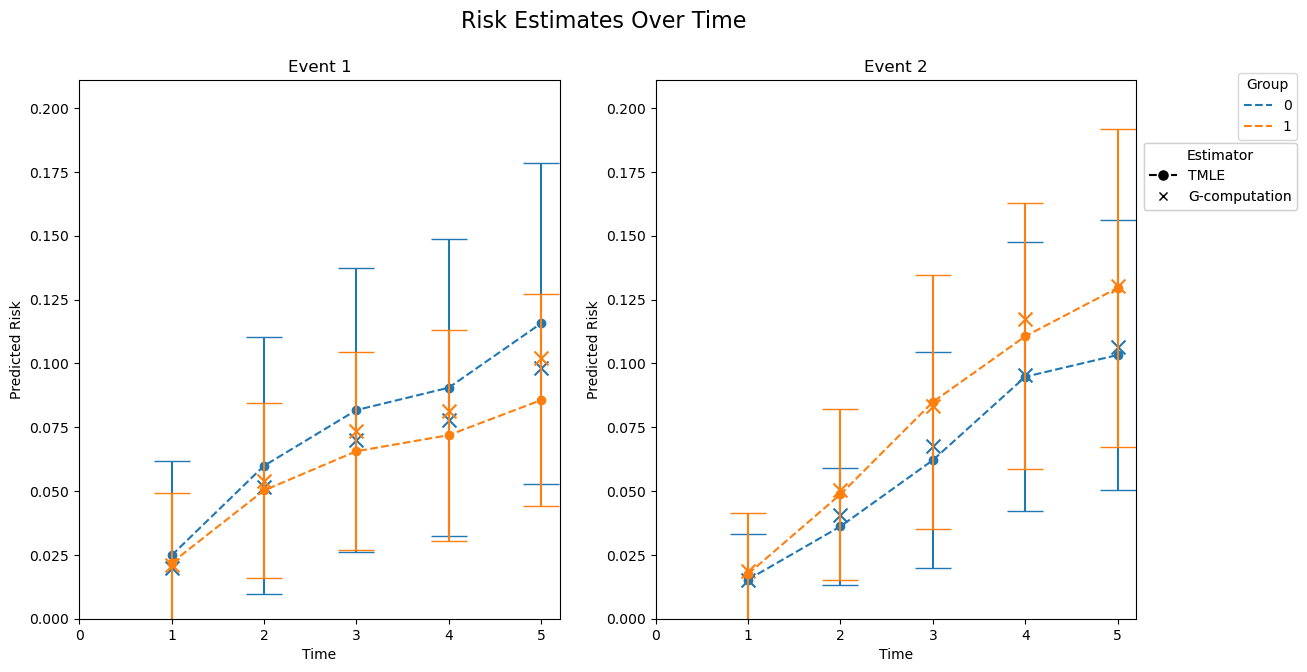

In [ ]:
tmle.plot(g_comp=True, use_bootstrap=False)

Plot the ATE estimates in terms of ratios. You can alternatively use `type="diff"` to use differences instead. If `bootstrap=True` was set in the `fit` method, you can also get bootstrapped quantile-based confidence intervals when setting `use_bootstrap=True`.

(<Figure size 1400x700 with 2 Axes>,
 array([<Axes: title={'center': 'Event 1'}, xlabel='Time', ylabel='ATE (Ratio)'>,
        <Axes: title={'center': 'Event 2'}, xlabel='Time', ylabel='ATE (Ratio)'>],
       dtype=object))

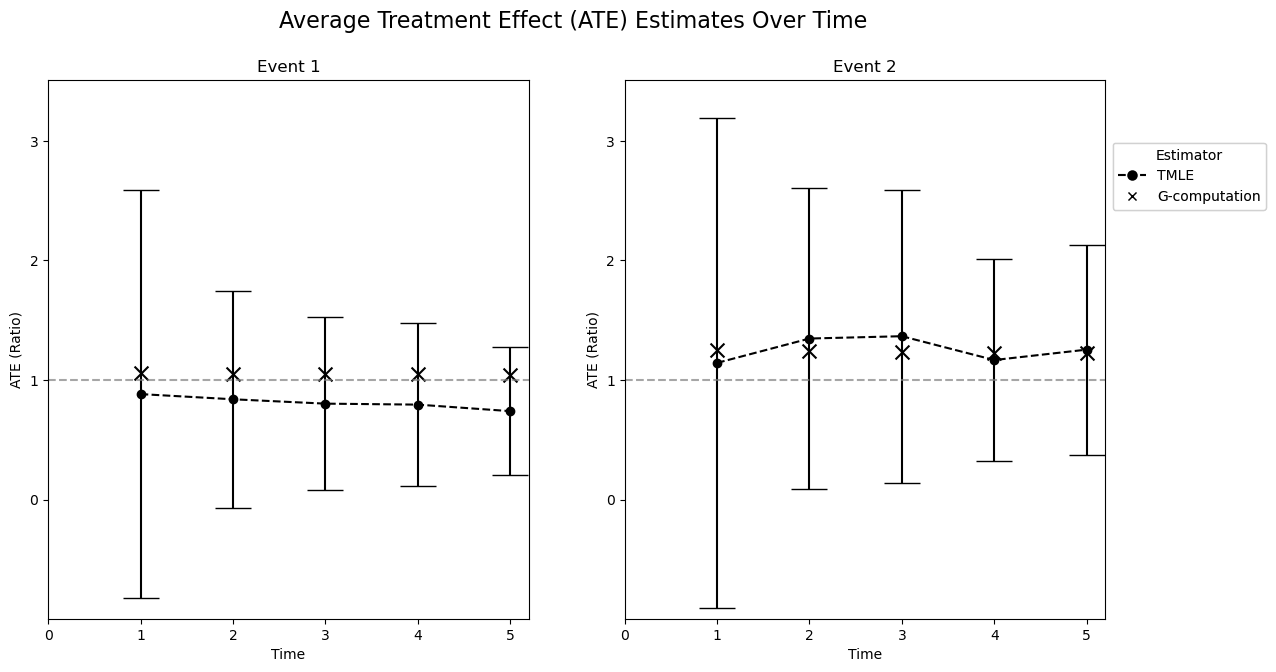

In [ ]:
tmle.plot(g_comp=True, type="ratio", use_bootstrap=False)

Plot $||PnEIC||$ over TMLE iterations to check that it was minimized effectively.

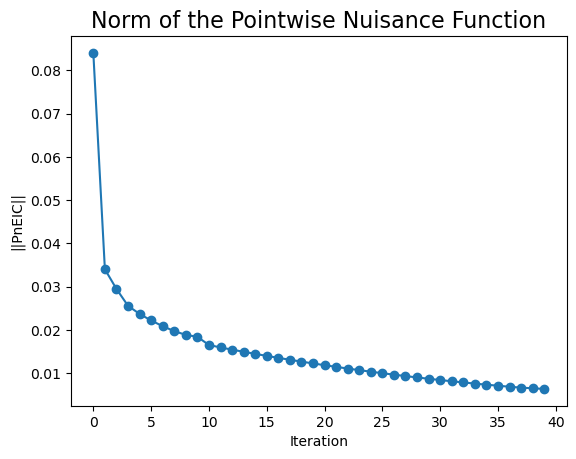

In [ ]:
tmle.plot_norm_pn_eic()

Plot the nuisance weights at baseline to check that positivity is not an issue. Set `time=None` to also get plots for baseline + all target times.

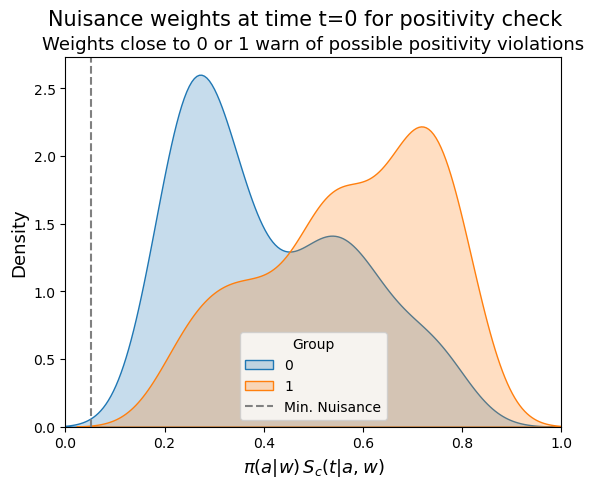

In [ ]:
tmle.plot_nuisance_weights(time=0)

Since `save_models` was set to `True` in the `fit()` call, you can extract the models used for initial estimates and analyze them further.

In [ ]:
tmle.models

{'propensity_model': StackingClassifier(cv=5,
                    estimators=[('rf', RandomForestClassifier()),
                                ('gb', GradientBoostingClassifier())],
                    final_estimator=LogisticRegression(max_iter=1000)),
 'event_1_model': CoxPHSurvivalAnalysis(),
 'event_2_model': CoxPHSurvivalAnalysis(),
 'censoring_model': CoxPHSurvivalAnalysis()}

Plot the contours of the E-value for the effect estimates at a specific time for a specific event. If `evalues_benchmark` was set to `True` when initializing the `PyTMLE` class (as in this notebook), E-values for observed covariates are included. If `bootstrap=True` was set in the `fit` method, you can also get the E-values for bootstrapped confidence intervals when setting `use_bootstrap=True`.

INFO:pytmle.evalues_benchmark:Plotting contour for point estimate only. Confidence interval is already tipped.


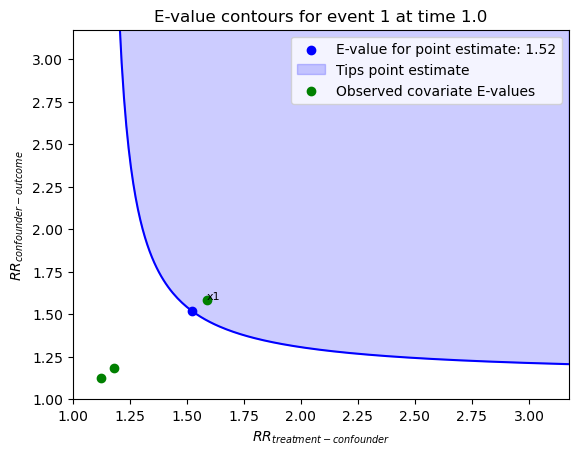

In [ ]:
tmle.plot_evalue_contours(time=1.0, event=1, type="ratio", use_bootstrap=False)

As the confidence interval is already tipped and the association of x1 with the outcome and treatment is even higher than it would need to be for a hypothetical unmeasured confounder to tip the point estimate (which makes it likely that such a confounder extists), the causal effect on event 1 at time 1.0 is clearly refuted.